### **Library Imports**

In [1]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
from torchvision import transforms

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

### **Utilities and Constants**

In [2]:
def breaker(num: int = 50, char: str = "*") -> None:
    print("\n" + num*char + "\n")

    
def show_graphs(L: list, A: list) -> None:
    TL, VL, TA, VA = [], [], [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.subplot(1, 2, 2)
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()


SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_PATH = "saves"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

### **Dataset Template**

In [3]:
class DS(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray = None, mode: str = "train", transform = None):

        assert re.match(r"^train$", mode, re.IGNORECASE) or re.match(r"^valid$", mode, re.IGNORECASE) or re.match(r"^test$", mode, re.IGNORECASE), "Invalid Mode"
        
        self.mode = mode
        self.images = images
        self.transform = transform

        if re.match(r"^train$", mode, re.IGNORECASE) or re.match(r"^valid$", mode, re.IGNORECASE):
            self.labels = labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        if re.match(r"^train$", self.mode, re.IGNORECASE) or re.match(r"^valid$", self.mode, re.IGNORECASE):
            return self.transform(self.images[idx]), torch.LongTensor(self.labels[idx])
        else:
            return self.transform(self.images[idx])

### **Model**

In [4]:
class CNN(nn.Module):
    def __init__(self, filter_sizes: list, HL: list, DP: float=None):
        
        super(CNN, self).__init__()
        
        self.features = nn.Sequential()
        self.features.add_module("CN1", nn.Conv2d(in_channels=1, out_channels=filter_sizes[0], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.features.add_module("BN1", nn.BatchNorm2d(num_features=filter_sizes[0], eps=1e-5))
        self.features.add_module("AN1", nn.ReLU())
        self.features.add_module("MP1", nn.MaxPool2d(kernel_size=(2, 2)))
        self.features.add_module("CN2", nn.Conv2d(in_channels=filter_sizes[0], out_channels=filter_sizes[1], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.features.add_module("BN2", nn.BatchNorm2d(num_features=filter_sizes[1], eps=1e-5))
        self.features.add_module("AN2", nn.ReLU())
        self.features.add_module("MP2", nn.MaxPool2d(kernel_size=(2, 2)))
        self.features.add_module("CN3", nn.Conv2d(in_channels=filter_sizes[1], out_channels=filter_sizes[2], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.features.add_module("BN3", nn.BatchNorm2d(num_features=filter_sizes[2], eps=1e-5))
        self.features.add_module("AN3", nn.ReLU())
        self.features.add_module("MP3", nn.MaxPool2d(kernel_size=(2, 2)))    

        self.classifier = nn.Sequential()
        if len(HL) == 0:
            self.classifier.add_module("FC1", nn.Linear(in_features=filter_sizes[2]*3*3, out_features=10))
        elif len(HL) == 1:
            self.classifier.add_module("FC1", nn.Linear(in_features=filter_sizes[2]*3*3, out_features=HL[0]))
            if isinstance(DP, float):
                self.classifier.add_module("DP1", nn.Dropout(p=DP))
            self.classifier.add_module("AN1", nn.ReLU())
            self.classifier.add_module("FC2", nn.Linear(in_features=HL[0], out_features=10))
        elif len(HL) == 2:
            self.classifier.add_module("FC1", nn.Linear(in_features=filter_sizes[2]*3*3, out_features=HL[0]))
            if isinstance(DP, float):
                self.classifier.add_module("DP1", nn.Dropout(p=DP))
            self.classifier.add_module("AN1", nn.ReLU())
            self.classifier.add_module("FC2", nn.Linear(in_features=HL[0], out_features=HL[1]))
            if isinstance(DP, float):
                self.classifier.add_module("DP2", nn.Dropout(p=DP))
            self.classifier.add_module("AN2", nn.ReLU())
            self.classifier.add_module("FC3", nn.Linear(in_features=HL[1], out_features=10))
        
        self.classifier.add_module("Final Activation", nn.LogSoftmax(dim=1))
    
    def get_optimizer(self, lr=1e-3, wd=0.0):
        params = [p for p in self.parameters() if p.requires_grad]
        return optim.Adam(params, lr=lr, weight_decay=wd)

    def get_plateau_scheduler(self, optimizer=None, patience=5, eps=1e-8):
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x)

### **Fit and Predict Helpers**

In [5]:
def fit(model=None, optimizer=None, scheduler=None, epochs=None, early_stopping_patience=None, dataloaders=None, fold=None, verbose=False) -> tuple:
    
    def get_accuracy(y_pred, y_true):
        y_pred = torch.argmax(y_pred, dim=1)
        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    if verbose:
        breaker()
        print(f"Training Fold {fold}...")
        breaker()

    bestLoss, bestAccs = {"train" : np.inf, "valid" : np.inf}, {"train" : 0.0, "valid" : 0.0}
    Losses, Accuracies = [], []
    name = f"state_fold_{fold}.pt"

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss, epochAccs = {"train" : 0.0, "valid" : 0.0}, {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass, accsPerPass = [], []

            for X, y in dataloaders[phase]:
                X, y = X.to(DEVICE), y.to(DEVICE).view(-1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.NLLLoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(get_accuracy(output, y))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)
        
        torch.save({"model_state_dict" : model.state_dict(),
                    "optim_state_dict" : optimizer.state_dict()},
                    os.path.join(SAVE_PATH, name))

        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict": model.state_dict(),
                            "optim_state_dict": optimizer.state_dict()},
                           os.path.join(SAVE_PATH, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            BAE = e + 1
        
        if scheduler:
            scheduler.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} |\
Train Accs: {:.5f} | Valid Accs: {:.5f} | Time: {:.2f} seconds".format(e+1, 
                                                                       epochLoss["train"], epochLoss["valid"], 
                                                                       epochAccs["train"], epochAccs["valid"], 
                                                                       time()-e_st))

    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print(f"Best Validation Accs at Epoch {BAE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
        breaker()
        print("Training Completed")
        breaker()

    return Losses, Accuracies, BLE, BAE, name


def predict(model=None, dataloader=None, path=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=DEVICE)["model_state_dict"])
    model.to(DEVICE)    
    model.eval()
    
    y_pred = torch.zeros(1, 1).to(DEVICE)
    
    for X in dataloader:
        X = X.to(DEVICE)
        with torch.no_grad():
            output = torch.argmax(torch.exp(model(X)), dim=1)
        y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    return y_pred[1:].detach().cpu().numpy()

### **Load Data**

In [6]:
train_df = pd.read_csv("../input/digit-recognizer/train.csv")
test_df  = pd.read_csv("../input/digit-recognizer/test.csv")

X = train_df.iloc[:, 1:].copy().values
y = train_df.iloc[:, 0].copy().values
X_test = test_df.copy().values

X = X.reshape(X.shape[0], 28, 28, 1).astype("uint8")
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype("uint8")

### **Params**

In [7]:
DEBUG = False

if DEBUG:
    n_splits = 3
    filter_sizes = [4]
    HL = [16]
    epochs = 2
else:
    n_splits = 5
    filter_sizes = [64, 128, 256]
    HL = [1024]
    epochs = 25
    
batch_size = 128
lr = 1e-3
wd = 0.0
early_stopping = 5
patience = None
eps = None

### **Train**


**************************************************

Training Fold 1...

**************************************************

Epoch: 1 | Train Loss: 0.26170 | Valid Loss: 0.05770 |Train Accs: 0.92597 | Valid Accs: 0.98210 | Time: 12.16 seconds
Epoch: 2 | Train Loss: 0.04650 | Valid Loss: 0.05055 |Train Accs: 0.98515 | Valid Accs: 0.98400 | Time: 5.75 seconds
Epoch: 3 | Train Loss: 0.03501 | Valid Loss: 0.03996 |Train Accs: 0.98841 | Valid Accs: 0.98743 | Time: 5.91 seconds
Epoch: 4 | Train Loss: 0.02734 | Valid Loss: 0.03878 |Train Accs: 0.99082 | Valid Accs: 0.98880 | Time: 5.91 seconds
Epoch: 5 | Train Loss: 0.02061 | Valid Loss: 0.03620 |Train Accs: 0.99272 | Valid Accs: 0.99022 | Time: 5.94 seconds
Epoch: 6 | Train Loss: 0.01506 | Valid Loss: 0.03507 |Train Accs: 0.99486 | Valid Accs: 0.99058 | Time: 6.04 seconds
Epoch: 7 | Train Loss: 0.01542 | Valid Loss: 0.06347 |Train Accs: 0.99495 | Valid Accs: 0.98345 | Time: 6.13 seconds
Epoch: 8 | Train Loss: 0.01053 | Valid Loss: 0.03353 |T

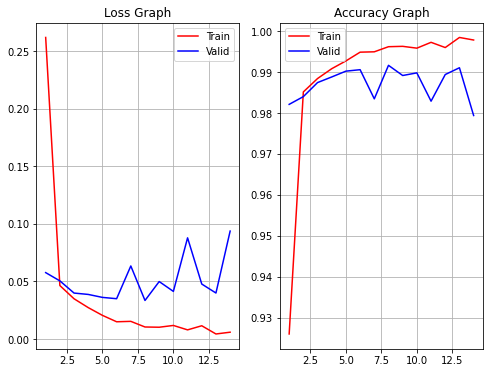


**************************************************

Training Fold 2...

**************************************************

Epoch: 1 | Train Loss: 0.20981 | Valid Loss: 0.06177 |Train Accs: 0.94115 | Valid Accs: 0.98071 | Time: 5.75 seconds
Epoch: 2 | Train Loss: 0.04943 | Valid Loss: 0.03613 |Train Accs: 0.98423 | Valid Accs: 0.98828 | Time: 5.88 seconds
Epoch: 3 | Train Loss: 0.03220 | Valid Loss: 0.04649 |Train Accs: 0.98999 | Valid Accs: 0.98584 | Time: 5.91 seconds
Epoch: 4 | Train Loss: 0.02146 | Valid Loss: 0.03505 |Train Accs: 0.99364 | Valid Accs: 0.98899 | Time: 5.84 seconds
Epoch: 5 | Train Loss: 0.01969 | Valid Loss: 0.03112 |Train Accs: 0.99409 | Valid Accs: 0.99053 | Time: 5.73 seconds
Epoch: 6 | Train Loss: 0.01843 | Valid Loss: 0.04796 |Train Accs: 0.99409 | Valid Accs: 0.98485 | Time: 5.81 seconds
Epoch: 7 | Train Loss: 0.01332 | Valid Loss: 0.03237 |Train Accs: 0.99554 | Valid Accs: 0.99041 | Time: 5.85 seconds
Epoch: 8 | Train Loss: 0.01320 | Valid Loss: 0.04077 |Tr

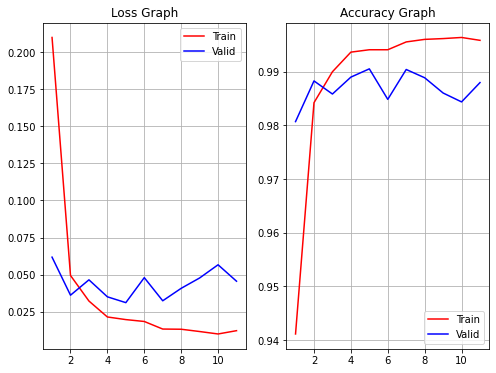


**************************************************

Training Fold 3...

**************************************************

Epoch: 1 | Train Loss: 0.22377 | Valid Loss: 0.08798 |Train Accs: 0.93542 | Valid Accs: 0.97401 | Time: 5.84 seconds
Epoch: 2 | Train Loss: 0.04827 | Valid Loss: 0.03754 |Train Accs: 0.98488 | Valid Accs: 0.98864 | Time: 5.81 seconds
Epoch: 3 | Train Loss: 0.03197 | Valid Loss: 0.04490 |Train Accs: 0.98945 | Valid Accs: 0.98662 | Time: 6.06 seconds
Epoch: 4 | Train Loss: 0.02563 | Valid Loss: 0.04941 |Train Accs: 0.99198 | Valid Accs: 0.98589 | Time: 5.95 seconds
Epoch: 5 | Train Loss: 0.02334 | Valid Loss: 0.03711 |Train Accs: 0.99240 | Valid Accs: 0.98857 | Time: 5.71 seconds
Epoch: 6 | Train Loss: 0.01677 | Valid Loss: 0.04235 |Train Accs: 0.99450 | Valid Accs: 0.98828 | Time: 5.92 seconds
Epoch: 7 | Train Loss: 0.01307 | Valid Loss: 0.04044 |Train Accs: 0.99593 | Valid Accs: 0.99034 | Time: 5.66 seconds
Epoch: 8 | Train Loss: 0.01585 | Valid Loss: 0.04790 |Tr

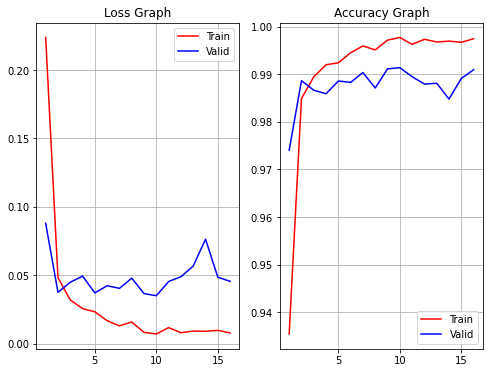


**************************************************

Training Fold 4...

**************************************************

Epoch: 1 | Train Loss: 0.25347 | Valid Loss: 0.05722 |Train Accs: 0.93126 | Valid Accs: 0.98165 | Time: 5.95 seconds
Epoch: 2 | Train Loss: 0.05219 | Valid Loss: 0.04963 |Train Accs: 0.98399 | Valid Accs: 0.98549 | Time: 6.02 seconds
Epoch: 3 | Train Loss: 0.03222 | Valid Loss: 0.05196 |Train Accs: 0.98951 | Valid Accs: 0.98163 | Time: 5.75 seconds
Epoch: 4 | Train Loss: 0.02476 | Valid Loss: 0.08615 |Train Accs: 0.99162 | Valid Accs: 0.97649 | Time: 5.86 seconds
Epoch: 5 | Train Loss: 0.02653 | Valid Loss: 0.03676 |Train Accs: 0.99147 | Valid Accs: 0.98958 | Time: 5.96 seconds
Epoch: 6 | Train Loss: 0.01848 | Valid Loss: 0.02418 |Train Accs: 0.99364 | Valid Accs: 0.99247 | Time: 5.86 seconds
Epoch: 7 | Train Loss: 0.01467 | Valid Loss: 0.02802 |Train Accs: 0.99507 | Valid Accs: 0.99176 | Time: 5.88 seconds
Epoch: 8 | Train Loss: 0.01136 | Valid Loss: 0.05593 |Tr

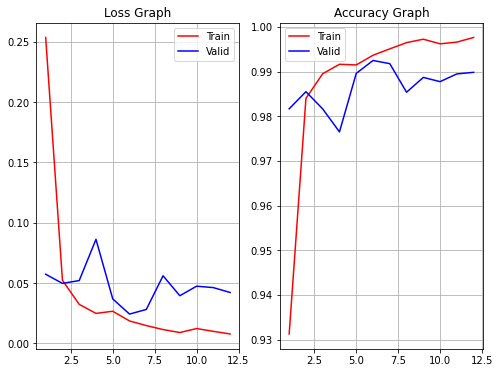


**************************************************

Training Fold 5...

**************************************************

Epoch: 1 | Train Loss: 0.22259 | Valid Loss: 0.04445 |Train Accs: 0.93557 | Valid Accs: 0.98696 | Time: 5.91 seconds
Epoch: 2 | Train Loss: 0.04706 | Valid Loss: 0.04392 |Train Accs: 0.98580 | Valid Accs: 0.98565 | Time: 5.69 seconds
Epoch: 3 | Train Loss: 0.03427 | Valid Loss: 0.05797 |Train Accs: 0.98925 | Valid Accs: 0.98329 | Time: 6.10 seconds
Epoch: 4 | Train Loss: 0.02755 | Valid Loss: 0.04090 |Train Accs: 0.99133 | Valid Accs: 0.98809 | Time: 6.06 seconds
Epoch: 5 | Train Loss: 0.01848 | Valid Loss: 0.07021 |Train Accs: 0.99385 | Valid Accs: 0.98063 | Time: 5.82 seconds
Epoch: 6 | Train Loss: 0.01568 | Valid Loss: 0.04495 |Train Accs: 0.99519 | Valid Accs: 0.98771 | Time: 5.90 seconds
Epoch: 7 | Train Loss: 0.01426 | Valid Loss: 0.04513 |Train Accs: 0.99531 | Valid Accs: 0.98809 | Time: 5.59 seconds
Epoch: 8 | Train Loss: 0.01104 | Valid Loss: 0.04388 |Tr

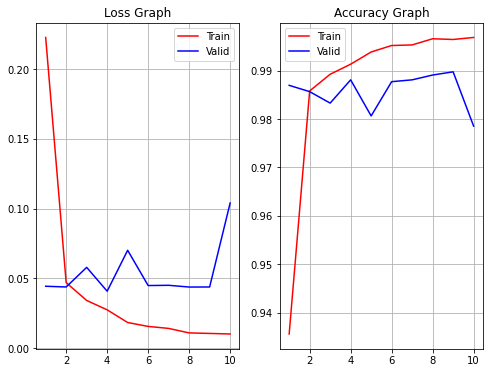


**************************************************

Best Loss Model : Fold 3
Best Accs Model : Fold 3

**************************************************



In [8]:
fold = 1
BLEs, BAEs = [], []

for tr_idx, va_idx in StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True).split(X, y):

    X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]

    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.13101], std=[0.30854]),
                                   ])

    tr_data_setup = DS(X_train, y_train.reshape(-1, 1), "train", transform)
    va_data_setup = DS(X_valid, y_valid.reshape(-1, 1), "valid", transform)

    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(SEED)),
        "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False),
    }

    torch.manual_seed(SEED)
    model = CNN(filter_sizes=filter_sizes, HL=HL, DP=0.25)
    model.to(DEVICE)
    optimizer = model.get_optimizer(lr=lr, wd=wd)
    scheduler = None
    if isinstance(patience, int) and isinstance(eps, float):
        scheduler = get_plateau_scheduler(optimizer=optimizer, patience=patience, eps=eps)

    L, A, BLE, BAE, name = fit(model=model, optimizer=optimizer, scheduler=scheduler, 
                               epochs=epochs, early_stopping_patience=early_stopping, 
                               dataloaders=dataloaders, fold=fold, verbose=True)

    show_graphs(L, A)
    BLEs.append(BLE)
    BAEs.append(BAE)
    fold += 1

breaker()
print(f"Best Loss Model : Fold {BLEs.index(max(BLEs)) + 1}")
print(f"Best Accs Model : Fold {BAEs.index(max(BAEs)) + 1}")
breaker()

### **Submission**

In [9]:
# ts_data_setup = DS(X_test, None, "test", transform)
# ts_data = DL(ts_data_setup, batch_size=batch_size, shuffle=False)

# y_hat = np.zeros((len(X_test), 1))

# for fold in range(1, n_splits + 1):
#     y_hat += predict(model=model, dataloader=ts_data, path=f"./saves/state_fold_{fold}.pt")

# y_pred = y_hat / 5

# ss_df = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
# ss_df["Label"] = y_pred.astype("int64")
# ss_df.to_csv("./submission.csv", index=False)